# 1- Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
# Set SEED
SEED = 42

# 2- Load data

In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e26/train.csv", index_col="id")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv", index_col="id")

# 3- EDA

In [4]:
# Display first few rows of the dataset
print("First Few Rows of the Dataset:")
table = tabulate(train_data.head(), headers='keys', tablefmt='pretty', showindex=False)


styled_table = f"\033[1m{table}\033[0m"
print(styled_table)

First Few Rows of the Dataset:
+--------+-----------------+-------+-----+---------+--------------+---------+-------+-----------+-------------+---------+--------+----------+--------+---------------+-----------+-------------+-------+--------+
| N_Days |      Drug       |  Age  | Sex | Ascites | Hepatomegaly | Spiders | Edema | Bilirubin | Cholesterol | Albumin | Copper | Alk_Phos |  SGOT  | Tryglicerides | Platelets | Prothrombin | Stage | Status |
+--------+-----------------+-------+-----+---------+--------------+---------+-------+-----------+-------------+---------+--------+----------+--------+---------------+-----------+-------------+-------+--------+
|  999   | D-penicillamine | 21532 |  M  |    N    |      N       |    N    |   N   |    2.3    |    316.0    |  3.35   | 172.0  |  1601.0  | 179.8  |     63.0      |   394.0   |     9.7     |  3.0  |   D    |
|  2574  |     Placebo     | 19237 |  F  |    N    |      N       |    N    |   N   |    0.9    |    364.0    |  3.54   |  63.0  

In [5]:
train_data.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,2030.173308,18373.146490,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,1094.233744,3679.958739,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,1831.000000,18713.000000,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,2689.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


***Visualize numerical features with enhanced aesthetics***

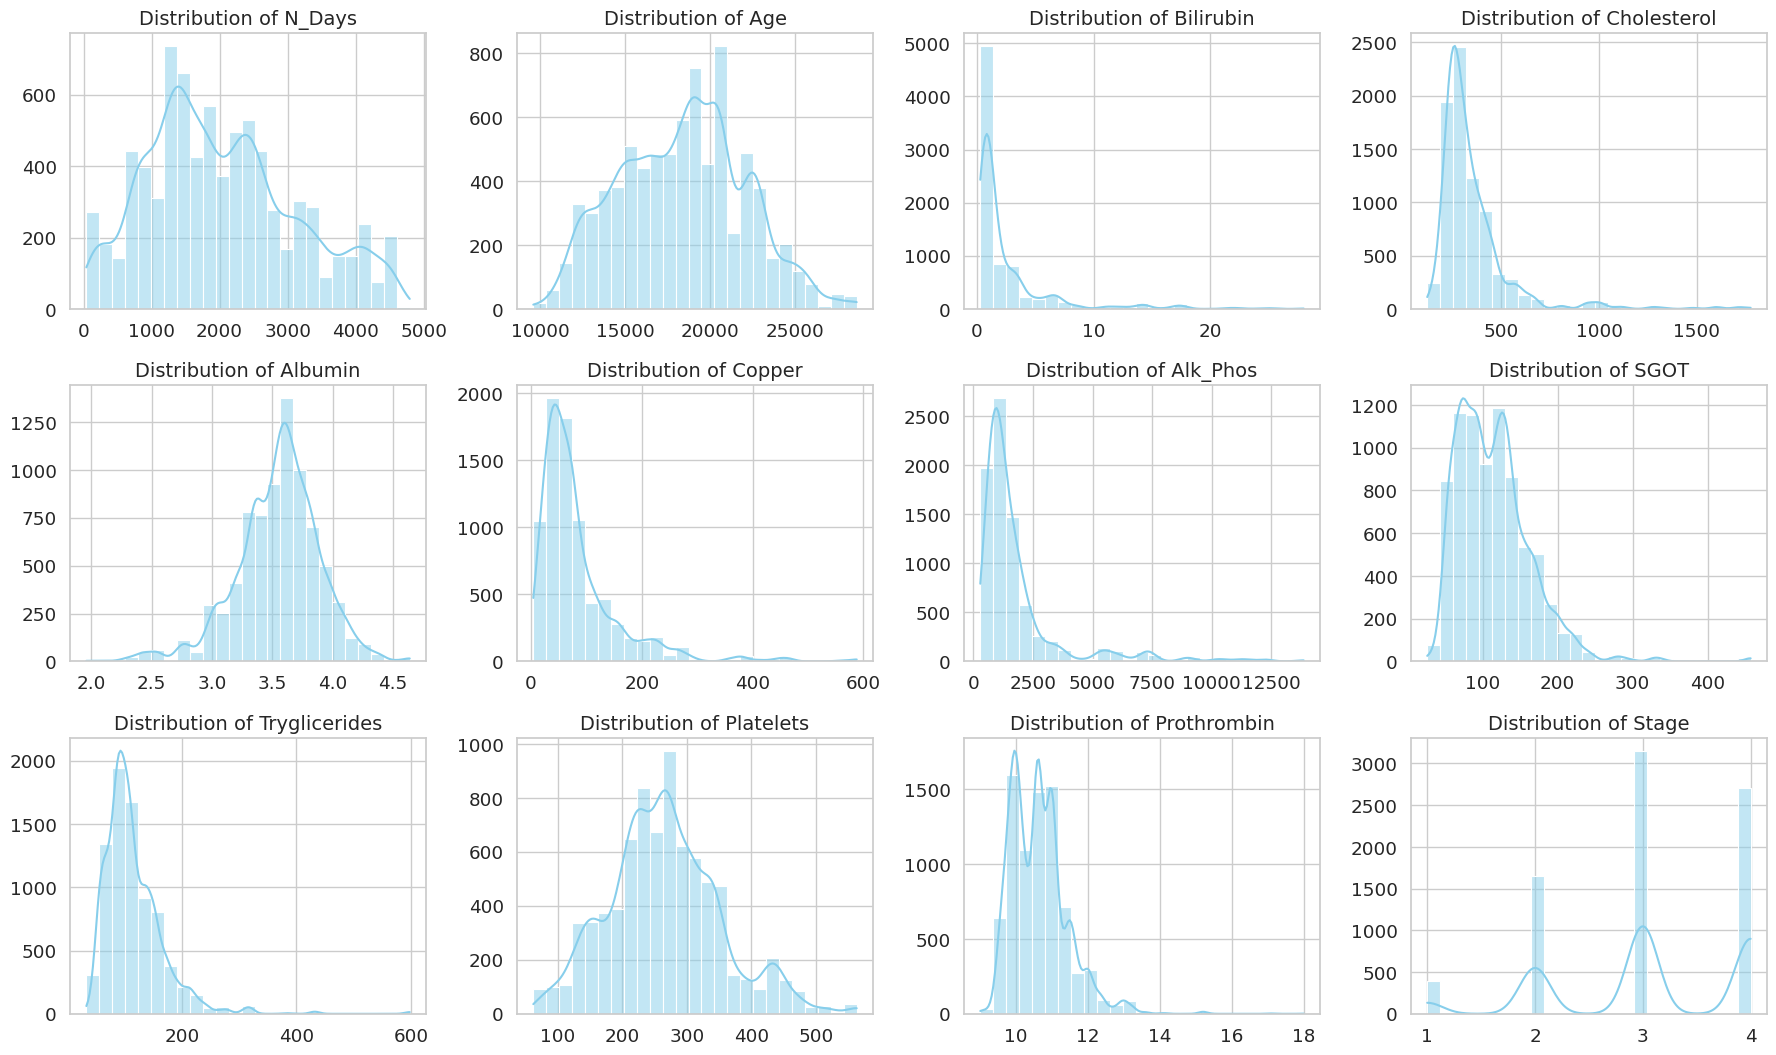

In [6]:

numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(18, 14))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(train_data[feature], kde=True, color='skyblue', bins=25)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

***Visualize categorical features***

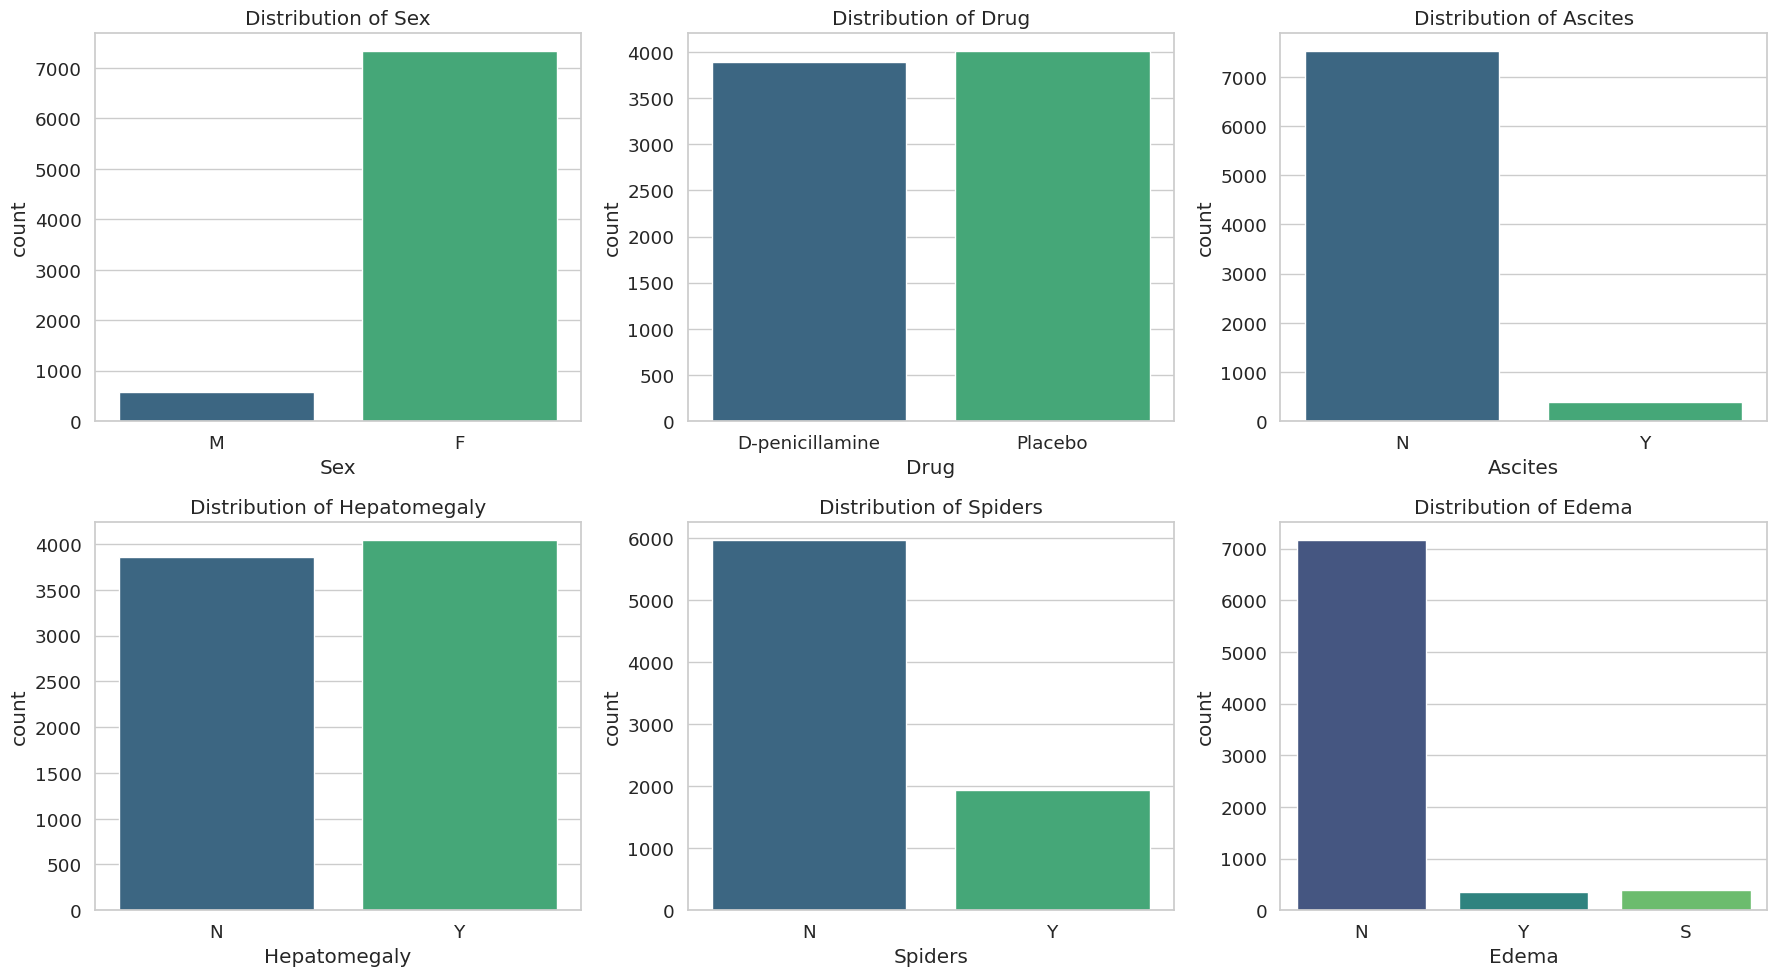

In [7]:

categorical_features = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

plt.figure(figsize=(18, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, data=train_data, palette='viridis')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

***Pie charts for 'Status' and Count Plot***

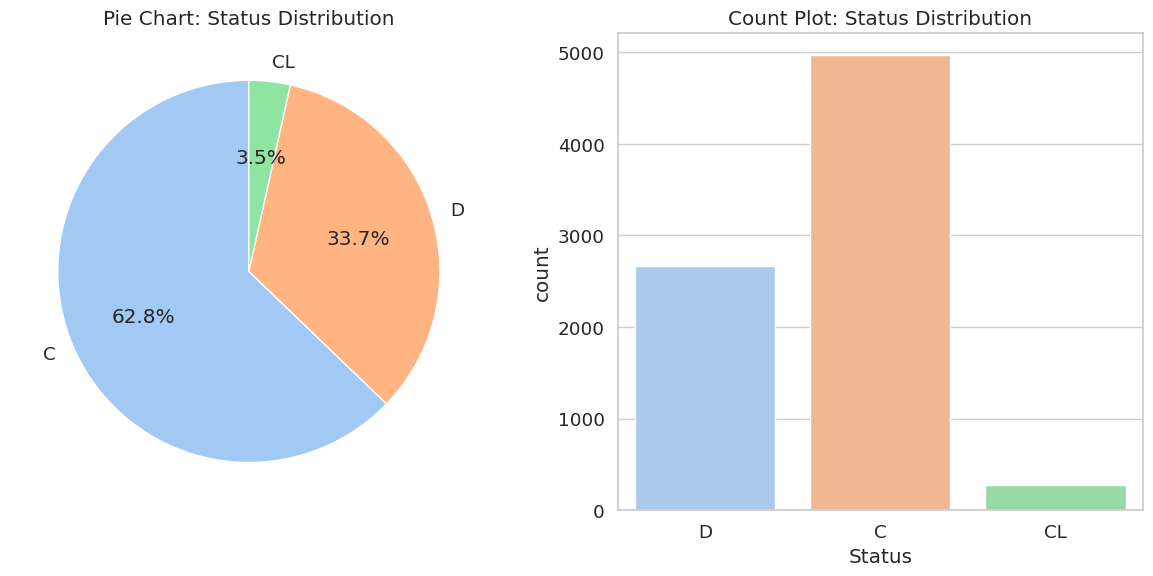

In [8]:
status_counts = train_data['Status'].value_counts()
labels = status_counts.index
sizes = status_counts.values

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Pie Chart: Status Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='Status', data=train_data, palette='pastel')
plt.title('Count Plot: Status Distribution')

plt.tight_layout()
plt.show()

***Visualize the relationship between numerical features and the target variable 'Status'***

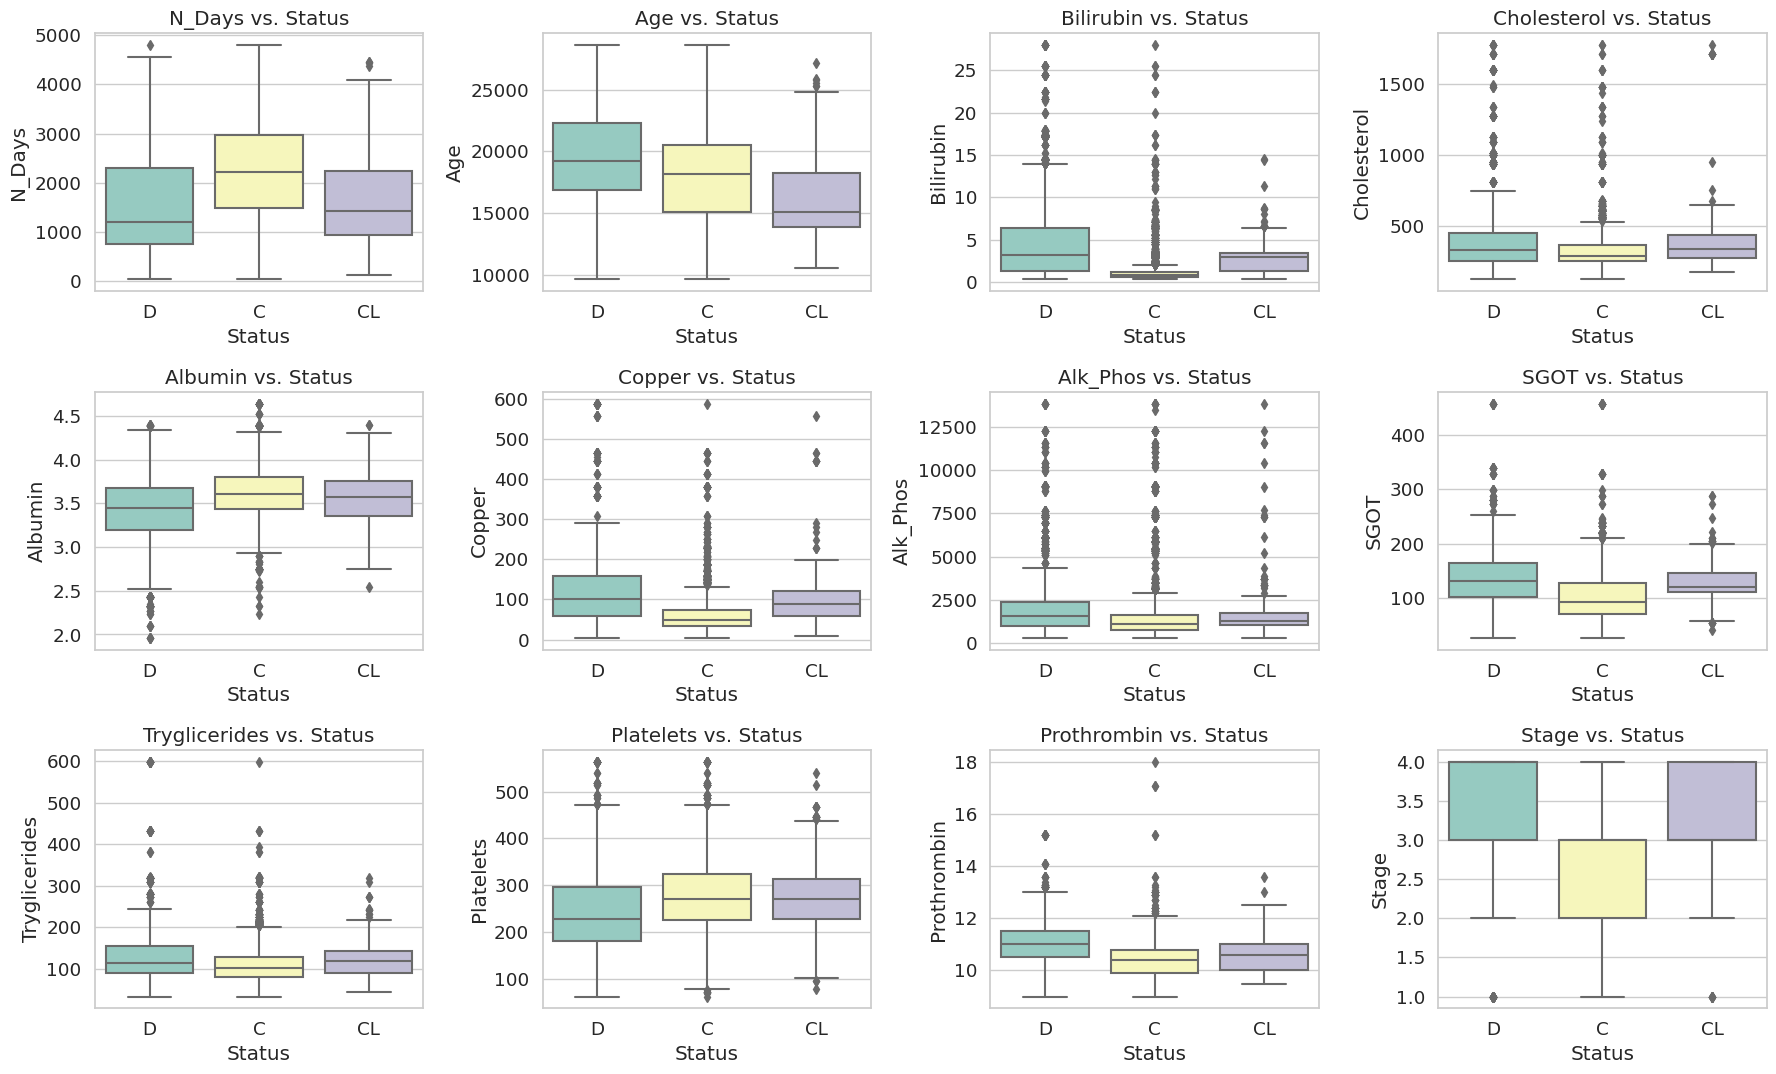

In [9]:
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

# Boxplots for numerical features
plt.figure(figsize=(18, 14))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='Status', y=feature, data=train_data, palette='Set3')
    plt.title(f'{feature} vs. Status')

plt.tight_layout()
plt.show()

***Pairplot for the selected numerical features***

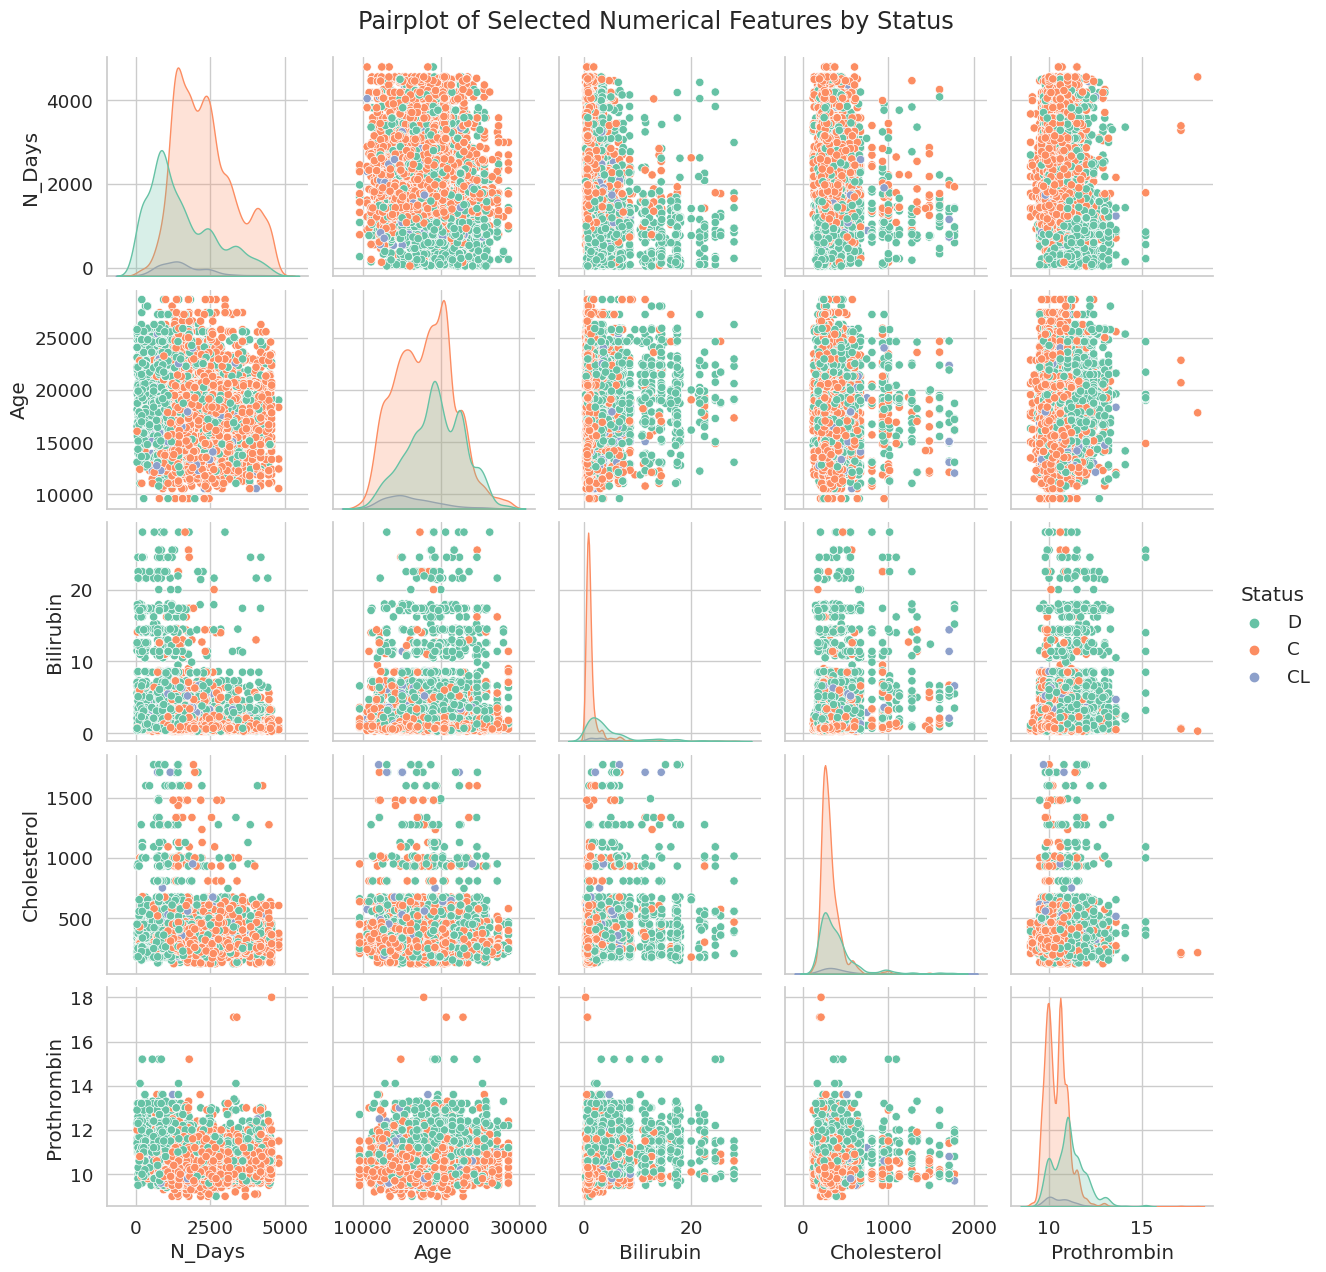

In [10]:
selected_numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Prothrombin']

sns.pairplot(train_data, hue='Status', vars=selected_numerical_features, palette='Set2')
plt.suptitle('Pairplot of Selected Numerical Features by Status', y=1.02)
plt.show()


***Visualize the distribution of target variable 'Status' across categorical features***

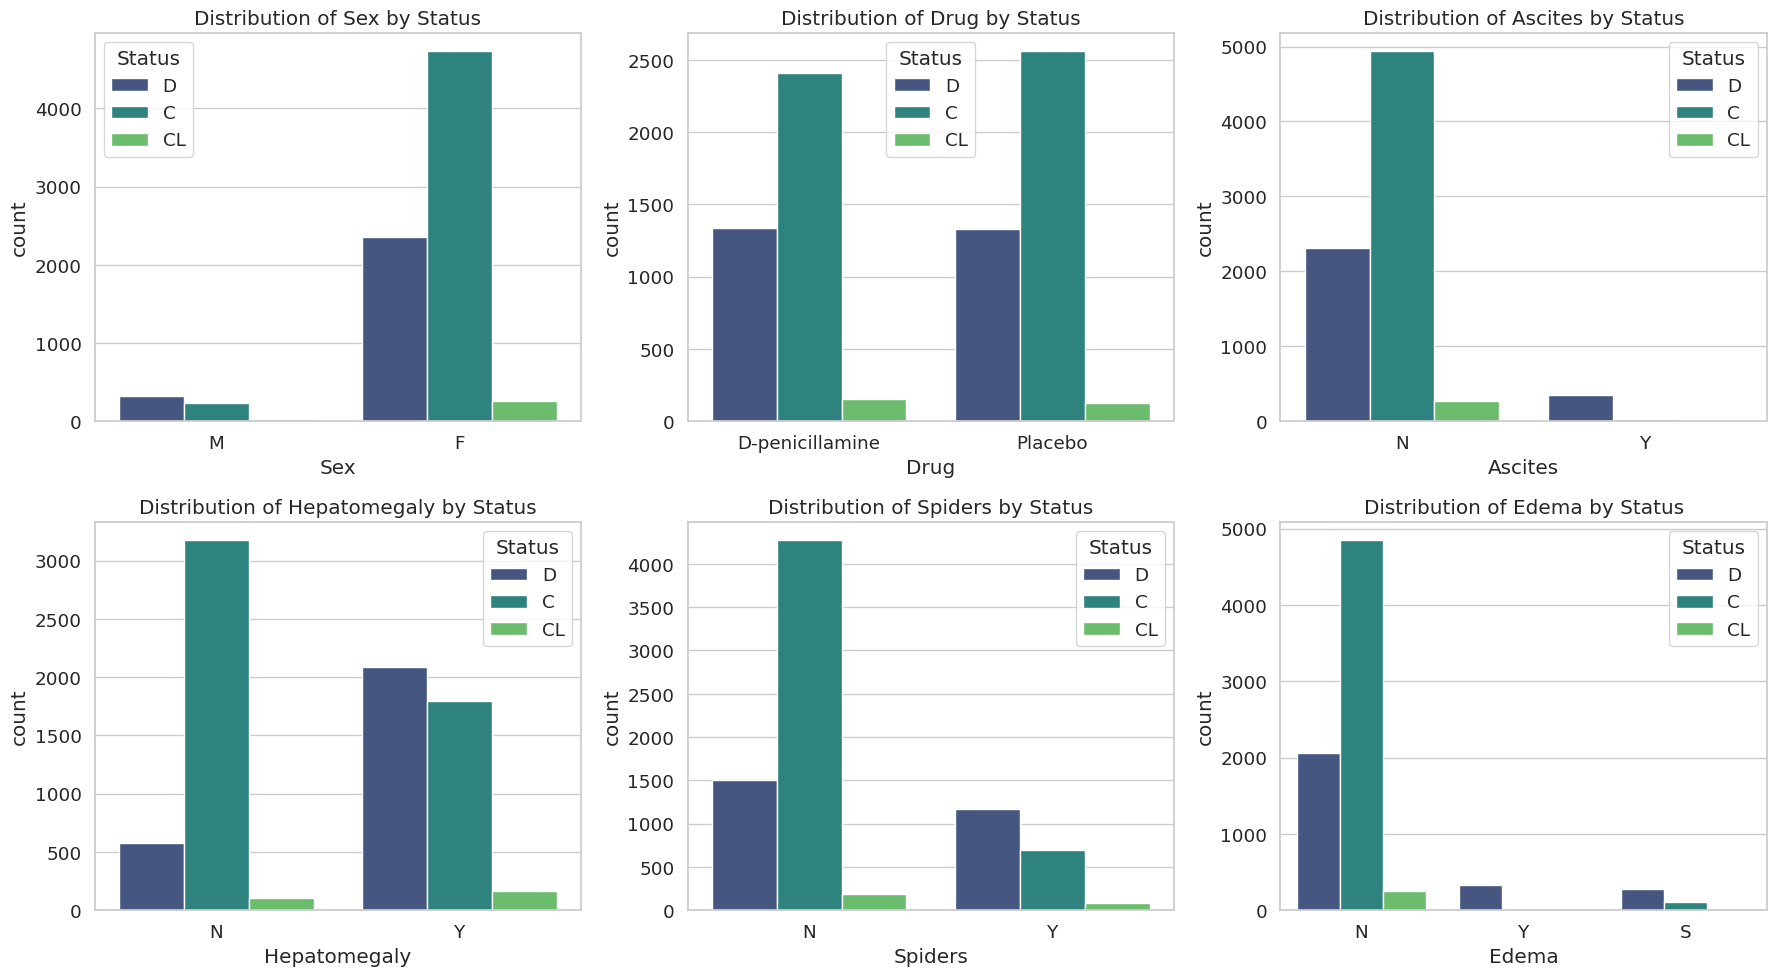

In [11]:
categorical_features = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

plt.figure(figsize=(18, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Status', data=train_data, palette='viridis')
    plt.title(f'Distribution of {feature} by Status')

plt.tight_layout()
plt.show()

# 4- Feature Engineering

***Define target***

In [12]:
target = "Status"

***Separate features and target***

In [13]:
X = train_data.drop(columns=[target])
y = train_data[target]

***Encode target variable***

In [14]:
le = LabelEncoder().fit(y)
y_encoded = le.transform(y)




***One-hot encode categorical features***

In [15]:
X = pd.get_dummies(X)

# 5- Model Building

***Define models***

In [16]:
xgb_clf = XGBClassifier(random_state=SEED, objective='multi:softprob', num_class=3)
lgb_clf = LGBMClassifier(random_state=SEED, objective='multiclass', num_class=3)
cat_clf = CatBoostClassifier(logging_level='Silent', random_state=SEED)
rf_clf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
gboost_clf = GradientBoostingClassifier(random_state=SEED)


***Define Voting Classifier***

In [17]:
eclf = VotingClassifier(
    estimators=[("xgb", xgb_clf), ("lgb", lgb_clf), ("cat", cat_clf), ("rf", rf_clf), ("gboost", gboost_clf)],
    voting="soft"
)


***Evaluate models***

In [18]:

def evaluate_model(model, X: pd.DataFrame, y: pd.DataFrame) -> list:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = le.transform(y.iloc[train_idx])

        X_val = X.iloc[val_idx]
        y_val = le.transform(y.iloc[val_idx])

        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)

        val_score = log_loss(y_val, y_pred)

        print(f"###### FOLD {fold + 1} ######")
        print(f"log loss: {val_score:.4f}")

        val_scores.append(val_score)

    mean_score = np.mean(val_scores)
    score_std = np.std(val_scores)

    print("#####################")
    print(f"Mean log_loss: {mean_score:.4f} +/- {score_std:.4f}.")
    return val_scores


***Fit the final model***

In [19]:
eclf.fit(X, y_encoded)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_class=3, num_parallel_tree=None, ...)),
                             ('lgb',
                              LGBMClassifier(num_class=3,
                                             objective='multiclass',
                                             random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7fef5c9ae2f0>),
                             ('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('gboost',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

***Make predictions on the test set***

In [20]:
X_test = pd.get_dummies(test_data)
test_predictions = eclf.predict_proba(X_test)


# 6- Prepare submission

In [21]:
submission_df = pd.DataFrame({
    'id': test_data.index,
    'Status_C': test_predictions[:, 0],
    'Status_CL': test_predictions[:, 1],
    'Status_D': test_predictions[:, 2]
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
